In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
import urllib3
import numpy as np
import os

In [3]:
from keras.models import Model, Input
from keras.layers import Conv2D, SeparableConv2D, Dense, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, BatchNormalization, Dropout
from keras.layers import Add
from keras.utils import to_categorical
from keras.callbacks import Callback
from keras.metrics import categorical_crossentropy
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import os
import numpy as np
import keras.backend as K

In [4]:
def conv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu', weight_decay=1e-5):
    x = Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    
    if activation:
        x = Activation(activation)(x)
    
    return x

def sepconv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu', weight_decay=1e-5, depth_multiplier=1):
    x = SeparableConv2D(filters, kernel_size, padding=padding, strides=strides, depth_multiplier=depth_multiplier, depthwise_regularizer=l2(weight_decay), pointwise_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    
    if activation:
        x = Activation(activation)(x)
    
    return x

# def preprocess_input(x):
#     return tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)


def Xception(model_input, classes):
    ## input_data scaling
    # x = preprocess_input(model_input)
    
    ## Entry flow
    x = conv2d_bn(model_input, 32, (3, 3), strides=2) # (299, 299, 3) -> (150, 150, 32)
    x = conv2d_bn(x, 64, (3, 3))

    for fliters in [128, 256, 728]: # (75, 75, 64) -> (75, 75, 128) -> (38, 38, 256) -> (19, 19, 728)
        residual = conv2d_bn(x, fliters, (1, 1), strides=2, activation=None)
        
        x = Activation(activation='relu')(x)
        x = sepconv2d_bn(x, fliters, (3, 3))
        x = sepconv2d_bn(x, fliters, (3, 3), activation=None)
        x = MaxPooling2D((3, 3), padding='same', strides=2)(x)
        
        x = Add()([x, residual])
        
        
    ## Middle flow
    for i in range(8): # (19, 19, 728)
        residual = x
        
        x = Activation(activation='relu')(x)
        x = sepconv2d_bn(x, 728, (3, 3))
        x = sepconv2d_bn(x, 728, (3, 3))
        x = sepconv2d_bn(x, 728, (3, 3), activation=None)
        
        x = Add()([x, residual])
        
        
    ## Exit flow
    residual = conv2d_bn(x, 1024, (1, 1), strides=2, activation=None) # (19, 19, 728) -> (10, 10, 1024)
        
    x = Activation(activation='relu')(x)
    x = sepconv2d_bn(x, 728, (3, 3))
    x = sepconv2d_bn(x, 1024, (3, 3), activation=None) # (19, 19, 728) -> (19, 19, 1024)
    x = MaxPooling2D((3, 3), padding='same', strides=2)(x) # (19, 19, 1024) -> (10, 10, 1024)
    
    x = Add()([x, residual])
    
    x = sepconv2d_bn(x, 1536, (3, 3))
    x = sepconv2d_bn(x, 2048, (3, 3))

    x = GlobalAveragePooling2D()(x)
    
    ## Optinal fully-connected layers
    x = Dense(4096)(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
#     x = Dense(4096)(x)
#     x = BatchNormalization()(x)
#     x = Activation(activation='relu')(x)
    
#     x = Dropout(0.4)(x)
    
    model_output = Dense(classes, activation='softmax')(x)
    # model_output = Dense(classes, activation='sigmoid')(x)

    model = Model(model_input, model_output, name='Xception')
    
    return model



In [5]:
from tensorflow import keras
model1 = keras.models.load_model('./models/xception_fake_well.h5')
model2 = keras.models.load_model('./models/xception_real_well.h5')

In [6]:
# labels = 'fake real'.split()
# labels = np.array(labels)
# labels


# prediction = [[0, 1]]
# # print({labels[i]: float(prediction[i]) for i in range(2)})
# np.array(prediction).flatten().tolist()

In [7]:
import gradio as gr
from PIL import Image

labels = 'fake real'.split()

def classify_image(inp):
    inp = inp.reshape((-1, 299, 299, 3))
    # inp = tf.keras.applications.xception.preprocess_input(inp)
    
    pred_fake_well = model1.predict(inp)
    pred_fake_well = np.array(pred_fake_well).flatten() # .tolist()
    pred_real_well = model2.predict(inp)
    pred_real_well = np.array(pred_real_well).flatten() # .tolist()

    # print(pred_fake_well)
    # print(pred_real_well)
    prediction = pred_fake_well*0.5 + pred_real_well*0.5
    
    # prediction = [pred_fake_well[i] + pred_real_well[i] for i in range(len(pred_fake_well))]
    # prediction = [prediction[i] * 0.5 for i in range(len(prediction))]
    print(prediction)
    # return 'Fake' if prediction[0][0] > prediction[0][1] else 'Real'
    # return 'Fake : %f' %(prediction[0][0] * 100)
    
#     real_stamp = Image.open('real.JPG')
#     fake_stamp = Image.open('fake.JPG')
    
    if np.argmax(prediction) == 1:
#         plt.imshow(real_stamp)
#         plt.show()
        stamp = Image.open('real_stamp.png')
    else:
#         plt.imshow(fake_stamp)
#         plt.show()
        stamp = Image.open('fake_stamp.png')
    
    # plt.cla()
    return {labels[i]: float(prediction[i]) for i in range(2)}, np.array(stamp)
    

image = gr.inputs.Image(shape=(299, 299))
label = gr.outputs.Label(num_top_classes=2)
'''
sample_images = [
                    ["129_36.jpg"],
                    ["145_470.jpg"],
                    ["157_18.jpg"],
                    ["176_150.jpg"],
                    ["179_180.jpg"],
]
'''


gr.Interface(# fn=[classify_image, classify_stamp],
             fn = classify_image,
             inputs=image, 
             # outputs=label,
             outputs = [gr.outputs.Label(num_top_classes=2), "image"],
             capture_session=True, 
             title="Real or Fake ?",
             # examples=sample_images
            ).launch()

Running locally at: http://127.0.0.1:7900/
To create a public link, set `share=True` in `launch()`.
Interface loading below...


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7900/', None)

[0.69705373 0.3029463 ]


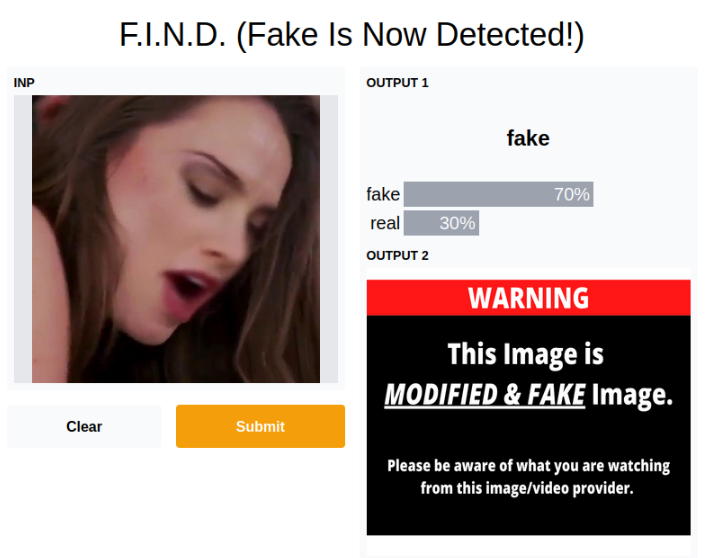

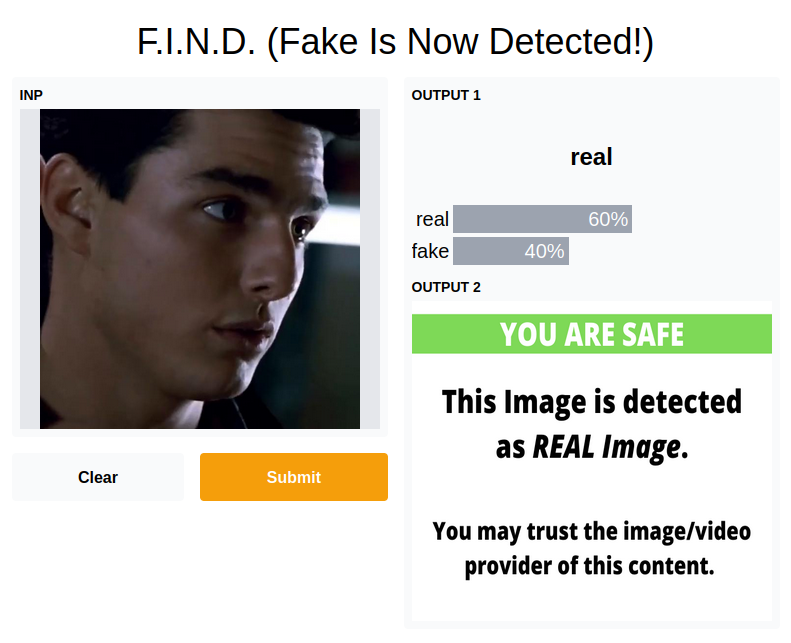